## To-do
* rethink data transformations
    * tail has varying skew strengths for different sites: use square root instead of log-transform for CO data?

## Notes
* **Data**
    * use precipitation and/or boundary layer height data?
    * remove outliers before normalizing? how to identify outliers?
    * focus on HYY, KPZ, NAN, MLP for now, then look at data from all cities combined
    * when using whole dataset think about the fact that seasons are opposite in southern hemisphere and that not all cities contribute the same amount of data points
* **Model**
    * focus on linear regression model of form: N100 = a + exp(b\*T + c) + d\*CO
    * train multiple models (2?) and combine them into a model later?
        * e.g. depending on temperature: when the temperature is high, CO should be almost irrelevant
        * use k-means to split data into two sets (two peaks in data)
    * look into interpretability of random forest models or using a combination of decision trees and linear regression models
        * random forests perform a lot better than linear regression
    
## Results
* using sin and cos of day of the year makes model performance worse, using the month improves it a bit, season and week of the year don't change much from month of the year
    * week of the year gives least extreme coefficients
* most errors seem to occur in the summer

## Importing Libraries

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Initiating directories

In [2]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

### Cities information, eg. to loop over city names:

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

In [3]:
print('All cities:')
print(cities.city.unique(), '\n')

city = cities.city[8]
print('Selected:', city)

All cities:
['ALE' 'ABZ' 'ASP' 'BOT' 'BSL' 'EGB' 'HEL' 'HPB' 'HYY' 'KCE' 'KPZ' 'MHD'
 'MAR' 'MLP' 'NAN' 'NEU' 'SAO' 'SCH' 'SGP' 'VIE' 'VAR' 'WAL'] 

Selected: HYY


## Loading and pre-processing the data

In [4]:
# loading the data
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')

# renaming the columns
df.columns = ['n100', 't', 'co']

# calculating the day of the year in order to get the week of the year (woy)
dates = df.index.tolist()
woy = [datetime.datetime.strptime(dates[i], "%Y-%m-%d").date() for i in range(len(dates))]
woy = np.array([woy[i].timetuple().tm_yday for i in range(len(woy))])
woy = woy / 7
woy = np.ceil(woy)

# adding the sin and cos of woy to the dataframe
df['woy_sin'] = np.sin(2*np.pi * woy/365)
df['woy_cos'] = np.cos(2*np.pi * woy/365)

# adding averages of the previous week (pwa) of t (t_pwa) and co (co_pwa) values to the df 
# (excluding the day measured in t and co)
pwa = 7

for col in ['t', 'co']:
    new_df = pd.DataFrame()
    
    for i in range(1, pwa+1):
        new_df[col + '_' + str(i)] = df.shift(i)[col]

    new_df = new_df.aggregate(np.mean, axis=1)
    df[col + '_pwa'] = new_df

# removing the rows containing NaN values in the previous 7 days
df = df[pwa:]
dates = dates[pwa:]

# reordering columns
df = df[['n100', 't', 't_pwa', 'co', 'co_pwa', 'woy_sin', 'woy_cos']]

# printing the first couple of rows
df.head()

,n100,t,t_pwa,co,co_pwa,woy_sin,woy_cos
date,,,,,,,
2003-01-08,648.683077,263.04785,249.529120,1.922008e-07,2.222959e-07,0.034422,0.999407
2003-01-09,177.328356,262.86664,251.343464,1.693421e-07,2.169822e-07,0.034422,0.999407
2003-01-10,515.932024,251.66493,253.066070,1.946702e-07,2.054784e-07,0.034422,0.999407
2003-01-11,285.454347,260.85300,253.566986,1.861436e-07,1.959475e-07,0.034422,0.999407
2003-01-12,232.010139,265.06660,255.566956,1.722488e-07,1.922792e-07,0.034422,0.999407


In [5]:
# calculating moving averages
window_size = 30
df_ma = df.copy().rolling(window=window_size).mean()[window_size:]

# normalizing the data (woy columns are not normalized because this leads to infinities in the log-transformed data)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.iloc[:,0:5].values)
x_scaled = np.concatenate((x_scaled, df.iloc[:,5:].values), axis=1)

df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df.columns.values

# log-transforming the data (currently transformes everything)
df_log = df_scaled.transform(np.log)

# calculating moving averages for log-transformed data
df_log_ma = df_log.copy().rolling(window=window_size).mean()[window_size:]

# removing rows that contain infinities
subset_mask = np.isinf(df_log).any(axis=1) == False

df_log_subset = df_log.loc[subset_mask]
df_scaled_subset = df_scaled.loc[subset_mask]
df_subset = df.reset_index().loc[subset_mask]
dates_subset = pd.Series(dates).loc[subset_mask]

## Visualizations

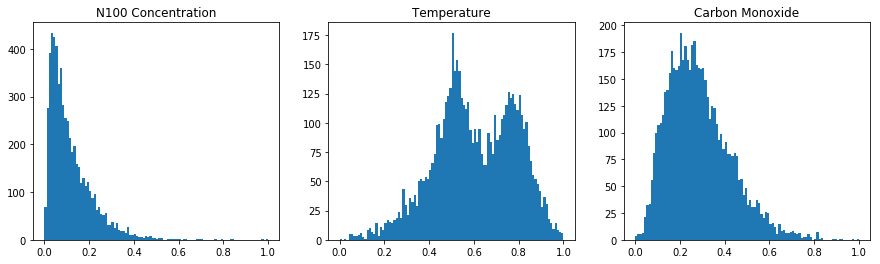

In [6]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_scaled.n100, bins=100)
ax[1].hist(df_scaled.t, bins=100)
ax[2].hist(df_scaled.co, bins=100)

ax[0].set_title('N100 Concentration')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide');

N100 Concentration and Carbon Monoxide have a high positive skew and should therefore be log-tranformed

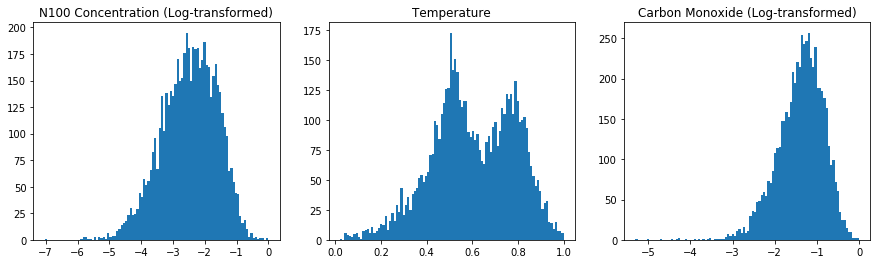

In [7]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_log_subset.n100, bins=100)
ax[1].hist(df_scaled_subset.t, bins=100)
ax[2].hist(df_log_subset.co, bins=100)

ax[0].set_title('N100 Concentration (Log-transformed)')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide (Log-transformed)');

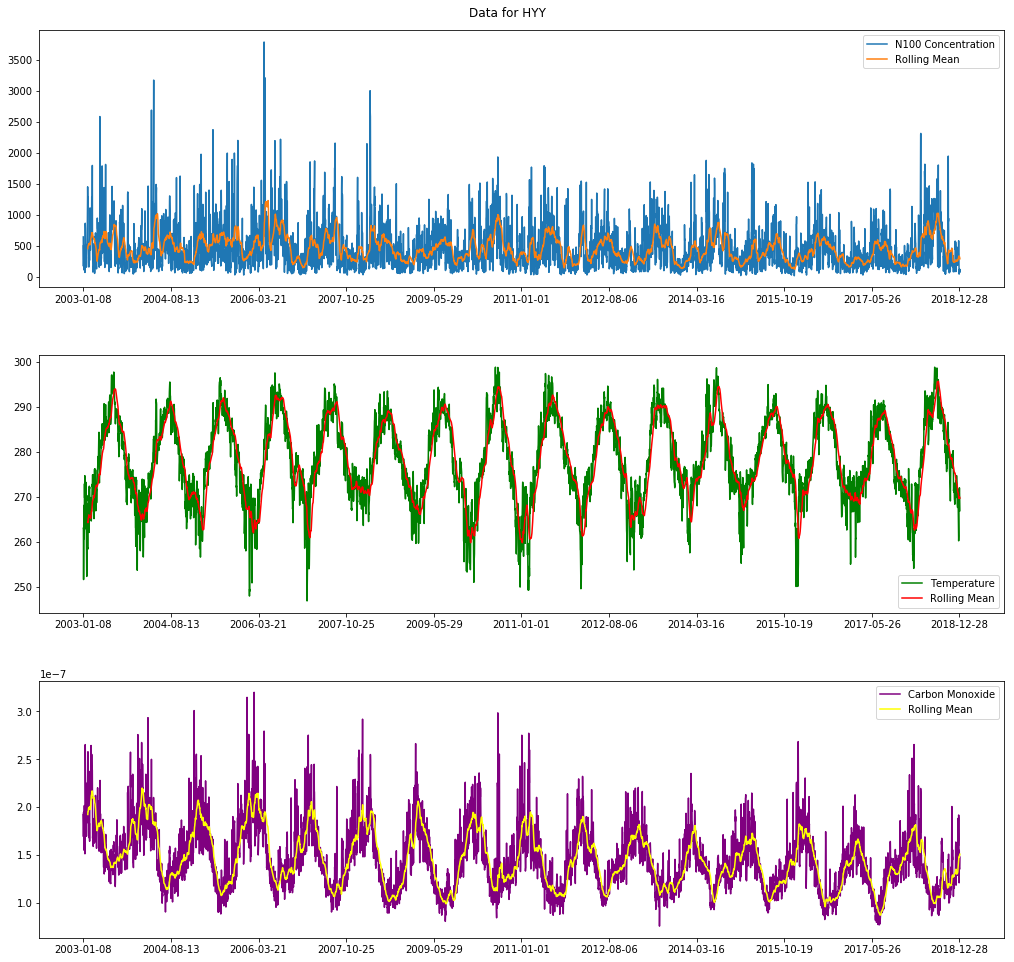

In [8]:
# plotting original data and trend (moving average)
idx = df.shape[0]
step = int(idx / 10)
xticks = pd.Series(df.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(15, 14)

ax[0].plot(df.n100[:idx], label='N100 Concentration')
ax[0].plot(df_ma.n100[:idx], label='Rolling Mean')

ax[1].plot(df.t[:idx], label='Temperature', c='green')
ax[1].plot(df_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Data for '+city);

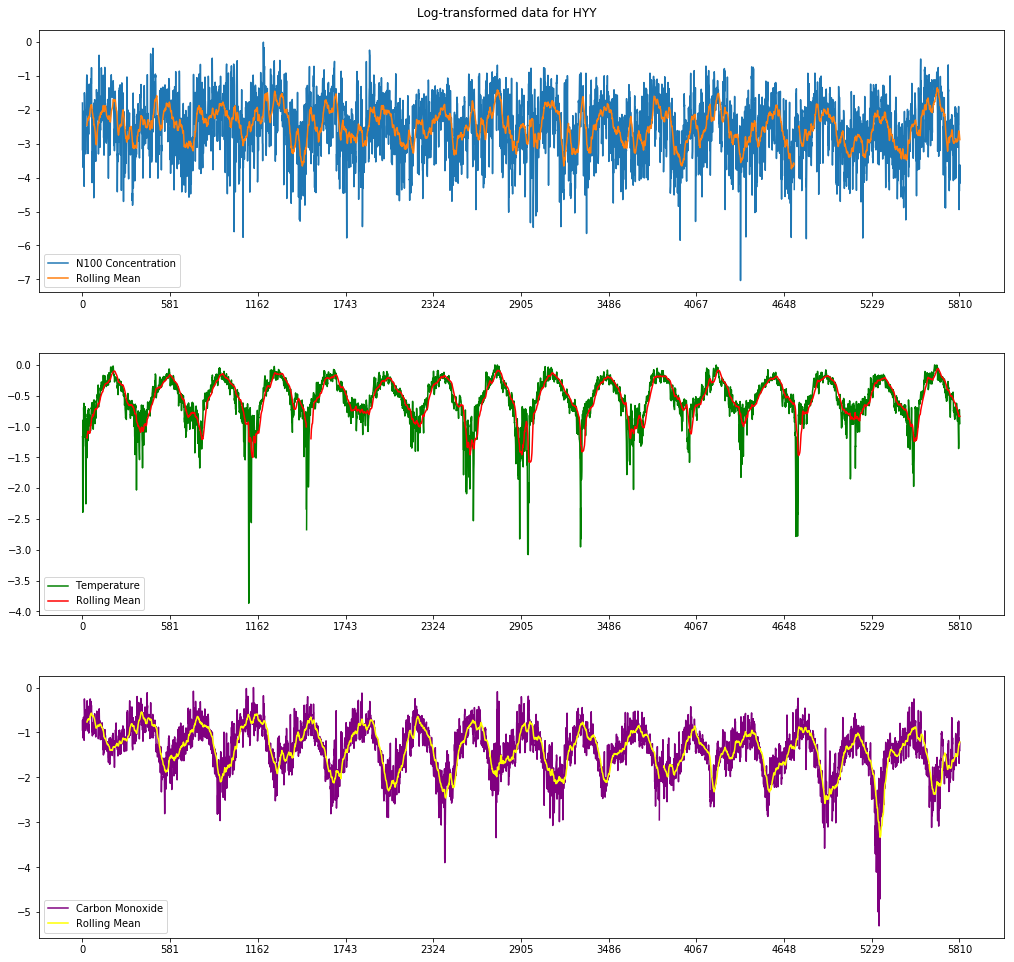

In [9]:
# plotting log-transformed data and trend (moving average)
idx = df_log.shape[0]
step = int(idx / 10)
xticks = pd.Series(df_log.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(15,14)

ax[0].plot(df_log.n100[:idx], label='N100 Concentration')
ax[0].plot(df_log_ma.n100[:idx], label='Rolling Mean')

ax[1].plot(df_log.t[:idx], label='Temperature', c='green')
ax[1].plot(df_log_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df_log.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_log_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Log-transformed data for '+city);

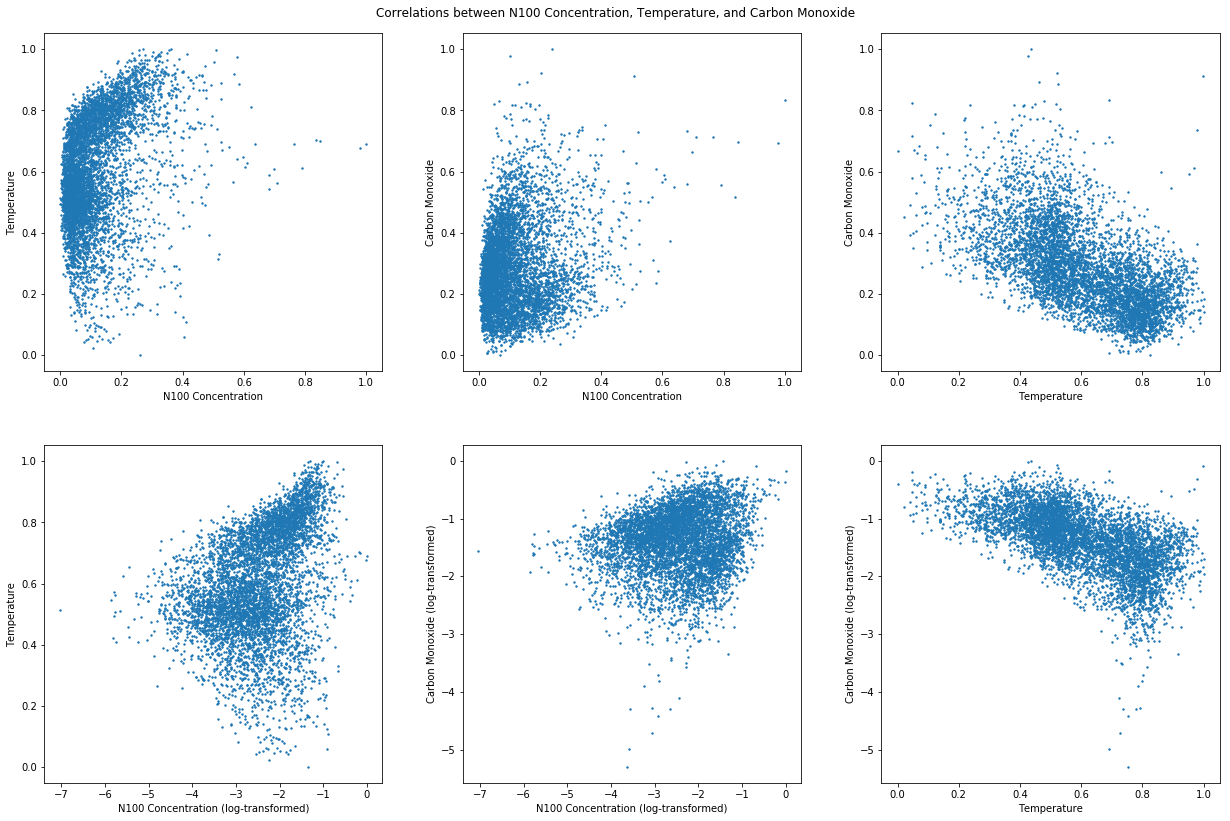

In [10]:
# plotting correlations of variables
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18,12)
fig.suptitle('Correlations between N100 Concentration, Temperature, and Carbon Monoxide')

ax[0, 0].scatter(df_scaled.n100, df_scaled.t, s=2)
ax[0, 1].scatter(df_scaled.n100, df_scaled.co, s=2)
ax[0, 2].scatter(df_scaled.t, df_scaled.co, s=2)

ax[1, 0].scatter(df_log.n100, df_scaled.t, s=2)
ax[1, 1].scatter(df_log.n100, df_log.co, s=2)
ax[1, 2].scatter(df_scaled.t, df_log.co, s=2)

for i in range(2):
    n100 = 'N100 Concentration'
    t = 'Temperature'
    co = 'Carbon Monoxide'
    
    if i == 1:
        log = ' (log-transformed)'
        n100 += log
        co += log
    
    ax[i, 0].set_xlabel(n100)
    ax[i, 1].set_xlabel(n100)
    ax[i, 2].set_xlabel(t)

    ax[i, 0].set_ylabel(t)
    ax[i, 1].set_ylabel(co)
    ax[i, 2].set_ylabel(co)
    
fig.tight_layout(pad=4);

In [11]:
pr = 3  # precision

# calculating correlation coefficients
print('NORMALIZED DATA')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_scaled.n100, df_scaled.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_scaled.n100, df_scaled.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled.t, df_scaled.co)[0,1], pr))

print('\n')
print('LOG-TRANSFORMED DATA (N100 and CO)')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_log_subset.n100, df_scaled_subset.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_log_subset.n100, df_log_subset.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled_subset.t, df_log_subset.co)[0,1], pr))

NORMALIZED DATA
Correlations between...
	N100 and T: 0.35
	N100 and CO: 0.188
	T and CO: -0.605


LOG-TRANSFORMED DATA (N100 and CO)
Correlations between...
	N100 and T: 0.354
	N100 and CO: 0.128
	T and CO: -0.599


* HEL: Using the log-transform actually made all the correlations stronger. (When also using a log-transform for the temperature data the correlation was weakened.)
* HYY: The correlations get a little bit weaker.



## Simple Scikit Learn Models
### Preparing the data

In [21]:
df_comb = pd.DataFrame(np.array([df_log_subset.n100,  # log-transformed N100 concentration
                                 df_scaled_subset.t, df_scaled_subset.t_pwa,  # normalized temperature
                                 df_log_subset.co, df_log_subset.co_pwa,  # log-transformed co
                                 df_subset.woy_sin, df_subset.woy_cos]).T)  # week of the year

df_comb.columns = df.columns.values
df_comb.head()

,n100,t,t_pwa,co,co_pwa,woy_sin,woy_cos
0,-3.192179,0.307211,0.037555,-0.960064,-0.220608,0.034422,0.999407
1,-2.032946,0.091367,0.073212,-0.720138,-0.308944,0.034422,0.999407
2,-2.662417,0.268411,0.083580,-0.794658,-0.388547,0.034422,0.999407
3,-2.889661,0.349602,0.124978,-0.929420,-0.420956,0.034422,0.999407
4,-3.700188,0.409175,0.173868,-1.124569,-0.452693,0.034422,0.999407


In [26]:
# splitting the data into training (75%) and testing (25%) sets
split = int(len(df_comb) * 0.75)  # index to split the data on

# dates
dates_test = dates_subset[split:len(df_subset)]

# n100
y_train= df_comb.n100[0:split]
y_test = df_subset.n100[split:len(df_subset)].reset_index(drop=True)
log_y_test = df_comb.n100[split:len(df_subset)].reset_index(drop=True)

# predictors
predictors = ['t', 't_pwa', 'co', 'co_pwa', 'woy_sin', 'woy_cos']
X_train = df_comb[predictors][0:split]
X_test = df_comb[predictors][split:len(df_comb)].reset_index(drop=True)

print('Predictors:', predictors, '\n')
print('Training data shapes:', X_train.shape, 'and', y_train.shape)
print('Testing data shapes:', X_test.shape, 'and', y_test.shape)

Predictors: ['t', 't_pwa', 'co', 'co_pwa', 'woy_sin', 'woy_cos'] 

Training data shapes: (4356, 6) and (4356,)
Testing data shapes: (1453, 6) and (1453,)


### Functions for evaluating models

In [28]:
# fitting a min_max_scaler to the concentration data (so that predicted values can be reverse transformed)
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df_subset.n100.values.reshape(-1,1))

# function for reverse transforming the data
def rev_trans(predictions):
    predictions = np.exp(predictions)
    predictions = min_max_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

pr = 3  # precision to be used for printing results

# function for printing the equation created by the linear regression model
def print_equation(model):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    print('Model equation:\nlog(N100) = min_max(T)*', coefs[0], ' + log(CO)*', coefs[1], ' + sin(MOY)*', coefs[2], 
          ' + cos(MOY)*', coefs[3], ' ', intercept, '\n', sep='')

# function for calculating the R2 value and RMSE
def eval_model(predictions, model):
    r2 = r2_score(y_test, predictions)
    print('R2 score:\n%.3f\n' % r2)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set:\n%.3f\n' % rmse)

# function for plotting the log-transformed observed and predicted n100 concentrations against each other
def log_log_eval(log_predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted Log-Transformed N100 Concentration')
    
    axis_min, axis_max = -7, 0
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(log_y_test, log_predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(log_y_test, log_predictions, s=2)
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted log-transformed N100 concentration:\n%.3f\n' %
          np.corrcoef(log_y_test, log_predictions)[0, 1])

# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration')
    
    axis_min, axis_max = 0, int(y_test.max())
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(y_test, predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(y_test, predictions, s=2, )
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted N100 concentration:\n%.3f\n' %
          np.corrcoef(y_test, predictions[:,0])[0, 1])
    
# function for plotting the predicted and observed n100 concentrations
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - Test Set')
    
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    
    xticks_mask = list(range(0, dates_test.shape[0], int(dates_test.shape[0] / 8)))
    xticks = dates_test.iloc[xticks_mask]
    plt.xticks(xticks_mask, xticks)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N100 concentration')

### Linear Regression

Model equation:
log(N100) = min_max(T)*2.588 + log(CO)*-0.614 + sin(MOY)*1.432 + cos(MOY)*-0.788 -7.853

Correlation between observed and predicted log-transformed N100 concentration:
0.582

Correlation between observed and predicted N100 concentration:
0.562

R2 score:
0.286

RMSE on test set:
272.778



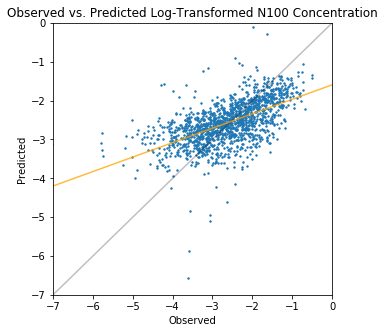

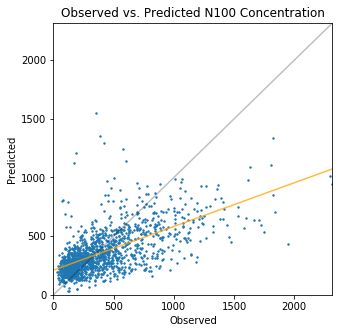

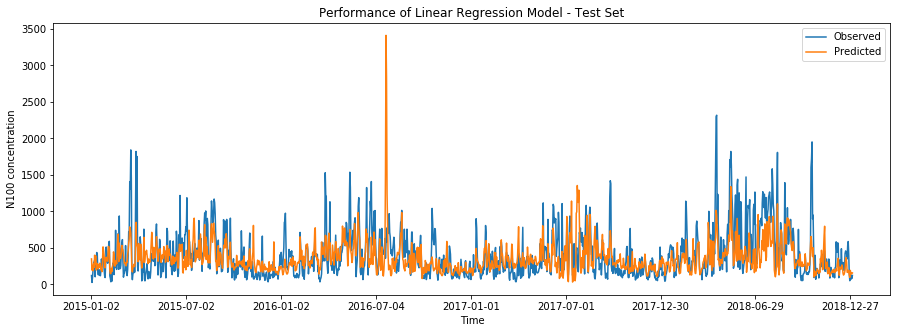

In [30]:
# Linear Regression
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
print_equation(model)
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Linear Regression', predictions)

High N100 concentrations are strongly underestimated

### Other Models

Correlation between observed and predicted log-transformed N100 concentration:
0.741

Correlation between observed and predicted N100 concentration:
0.753

R2 score:
0.536

RMSE on test set:
219.965



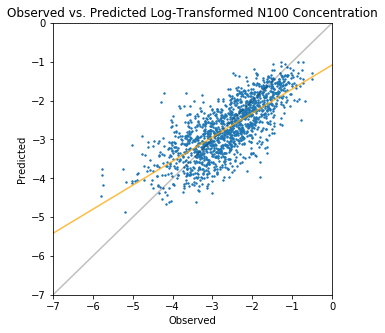

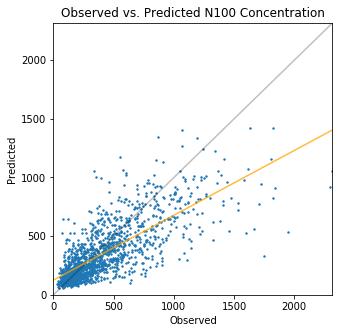

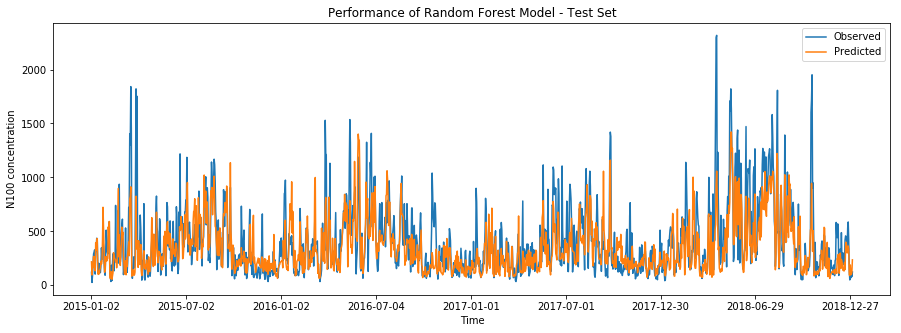

In [31]:
# Random Forest
model = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Random Forest', predictions)

The random forest model seems to give by far the best performance but is a black-box algorithm